In [8]:
from tqdm import tqdm
import wandb
api = wandb.Api(timeout=180)
import os
import pandas as pd
import wandb
import yaml
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
import argparse
import itertools
import  matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import time
import matplotlib as mpl
import matplotlib.ticker as ticker


In [9]:
USER='wilderlavington' 
PROJECT='FunctionalOptimization'
SUMMARY_FILE='aistats_fig1.csv' 
K=1
try:
    os.makedirs("plots/aistats/")
except FileExistsError:
    print("File already exists")

File already exists


In [ ]:
download_wandb_summary(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [ ]:
download_wandb_records(user=USER, project=PROJECT, summary_file=SUMMARY_FILE)

In [10]:
def smooth(array, k):
    array = np.array(array)
    new_array = deepcopy(array)
    # print(array[max(0,i-k):i] )
    for i in range(len(array)):
        if str(array[i]) != 'nan':
            avg_list = [val for val in array[max(0,i-k):i+1] if str(val) != 'nan']
            new_array[i] = sum(avg_list) / len(avg_list)
    return new_array
def format_dataframe(records, id_subfields={}, avg_subfields=['seed'],
            max_subfields=['log_lr'],
            x_col='optim_steps', y_col='avg_loss'):
    #
    pd.set_option('display.max_columns', None)
    max_subfields = [m for m in max_subfields if m not in id_subfields.keys()]
    for key in id_subfields:  
        records = records.loc[records[key] == id_subfields[key]] 
    records['function_evals+grad_evals'] = records['function_evals']+records['grad_evals']
    if not len(records):
        return None
    # remove nans
    records = records[records[y_col].notna()]
    important_cols = list(set(avg_subfields+max_subfields+\
        list(id_subfields.keys())+[x_col, y_col, 'optim_steps']))
    # remove redundant information
    records = records[important_cols]
    # average over avg_subfields
    records = records.drop(avg_subfields, axis=1)
    # group over averaging field
    gb = list(set(list(max_subfields+list(id_subfields.keys())+[x_col, 'optim_steps'])))
    # only look at final optim steps
    last_mean_records = records.loc[records['optim_steps'] == records['optim_steps'].max()]
    # get the best record
    best_record = last_mean_records[last_mean_records[y_col] == last_mean_records[y_col].min()]
    # find parameters of the best record
    merge_on = list(set(gb)-set(['optim_steps', x_col, y_col]))
    merge_on = [ x for x in merge_on if x in best_record.columns.values]
    best_records = pd.merge(best_record[merge_on], records, on=merge_on,how='left')
    final_records = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].mean()
    final_records[y_col+'25'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.25)[y_col]
    final_records[y_col+'75'] = best_records.groupby(merge_on+[x_col], as_index=False)[y_col].quantile(0.75)[y_col]
    final_records = final_records.sort_values(x_col, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    # smooth outputs 
    final_records[y_col+'75'] = smooth(final_records[y_col+'75'],K)
    final_records[y_col+'25'] = smooth(final_records[y_col+'25'],K)
    final_records[y_col] = smooth(final_records[y_col],K) 
    # return 
    return final_records

In [11]:
def generate_plot(proc_df, x, y, ax, label, linestyle='solid', color=None, x_max=5000000):
    low_order_idx = (torch.tensor(proc_df[x].values) < x_max).nonzero().reshape(-1)
    if label:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label=label, linestyle=linestyle, color=color, alpha=0.8,
                linewidth=4)
    else:
        ax.plot(torch.tensor(proc_df[x].values[low_order_idx]), 
                torch.tensor(proc_df[y].values[low_order_idx]), 
                label='_nolegend_', linestyle=linestyle, color=color, alpha=0.8,
                linewidth=4)
    ax.fill_between(torch.tensor(proc_df[x].values)[low_order_idx],
            torch.tensor(proc_df[y+'75'].values)[low_order_idx],
            torch.tensor(proc_df[y+'25'].values)[low_order_idx], 
            alpha = 0.4, label='_nolegend_', linestyle=linestyle, color=color)
    return ax

In [12]:
def generate_mfac_figure(loss, wandb_records):
    
    # base info   
    dataset_name =  'mfac' 
    batch_sizes = [25, 125, 625]
    m = [1, 5, 10, 20]
    x = 'optim_steps'
    y = 'avg_loss'
    schedules = ['constant', 'stochastic', 'exponential']
    wandb_records = wandb_records[wandb_records['group']=='AIstats_narval']
    # init plots 
    fig, axs = plt.subplots(len(schedules), len(batch_sizes)+1, figsize=(16, 8))
    colors = mpl.cm.Set1.colors   # Qualitative colormap
    colormap = {'SGD': '#44AA99' , 'SLS': '#DDCC77'}
    colormap.update({'SSO-1':  '#CC6677' ,  'SSO-5': '#AA4499', 'SSO-10': '#882255' , 'SSO-20': '#332288'})
    algorithms = ['SGD', 'SLS'] + ['SSO-'+str(m_) for m_ in m]
#     plt.title('Comparison of SGD, SLS, Functional-SGD: '+loss)
    label_map = {x:'Optimization-Steps', y:'Gradient-Norm'}
    
    # now add in the lines to each of the plots 
    for row, schedule in enumerate(schedules):
        
        # figure out axis automatically 
        x_max = 0 

        # SLS
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 0, 'loss': loss, 'algo': 'LSOpt',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None:
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SLS', 
                                         linestyle='dashed', color=colormap['SLS'])
        else:
            print('missing SLS  ', dataset_name, 'full-batch')

        # SGD
        proc_df = format_dataframe(wandb_records,
            id_subfields={'fullbatch': 1,  
            'use_optimal_stepsize': 0, 'loss': loss, 'algo': 'SGD',
            'eta_schedule': schedule, 'dataset_name': dataset_name},
            x_col=x , y_col=y) 
        if proc_df is not None: 
            x_max = max(proc_df[x].values.max(), x_max)
            axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1], label='SGD', 
                                         linestyle='dashed', color=colormap['SGD'])
        else:
            print('missing SGD  ', dataset_name, 'full-batch')
        # FMDopt theoretical 
        for m_ in m:
            # create parsed info 
            proc_df = format_dataframe(wandb_records, 
                id_subfields={'fullbatch': 1,   
                    'use_optimal_stepsize': 0, 
                    'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                    'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                     avg_subfields=['seed'], max_subfields=['c'],
                x_col=x, y_col=y)
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][-1] = generate_plot(proc_df, x, y, axs[row][-1],  \
                                        label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
            else:
                print('missing FMDopt  ', m_, dataset_name, 'full-batch')
                
        axs[row][-1].grid()     
        axs[row][-1].set_yscale("log")
        axs[row][-1].set_xscale("log")

        # mini-batch plots 
        for col, batch_size in enumerate(batch_sizes):
            
            # figure out axis automatically 
            x_max = 0 
            
            # SLS
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size,  #'_step': 499.0,
                'use_optimal_stepsize': 0, 'loss': loss, 'algo': 'LSOpt',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None:
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SLS', 
                                             linestyle='dashed', color=colormap['SLS'])
            else:
                print('missing SLS  ', dataset_name, batch_size)
            
            # SGD
            proc_df = format_dataframe(wandb_records,
                id_subfields={'batch_size': batch_size, #'_step': 499.0,
                'use_optimal_stepsize': 0, 'loss': loss, 'algo': 'SGD',
                'eta_schedule': schedule, 'dataset_name': dataset_name},
                x_col=x , y_col=y) 
            if proc_df is not None: 
                x_max = max(proc_df[x].values.max(), x_max)
                axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], label='SGD', 
                                             linestyle='dashed', color=colormap['SGD'])
            else:
                print('missing SGD  ', dataset_name, batch_size)
    
            # FMDopt theoretical 
            for m_ in m:
                # create parsed info 
                proc_df = format_dataframe(wandb_records, 
                    id_subfields={'batch_size': batch_size,  
                        'use_optimal_stepsize': 0, #'_step': 499.0,
                        'loss': loss, 'algo': 'SGD_FMDOpt', 'm': m_,
                        'eta_schedule': schedule, 'dataset_name': dataset_name}, 
                         avg_subfields=['seed'], max_subfields=['c'],
                    x_col=x, y_col=y)
                if proc_df is not None:
                    x_max = max(proc_df[x].values.max(), x_max)
                    axs[row][col] = generate_plot(proc_df, x, y, axs[row][col], \
                                            label='SSO-'+str(m_), linestyle='solid', color=colormap['SSO-'+str(m_)])
                else:
                    print('missing FMDopt  ', m_, dataset_name, batch_size)
            
            axs[row][col].grid()    
            axs[row][col].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
            axs[row][col].yaxis.set_major_locator(plt.MaxNLocator(4))
            axs[row][col].set_yscale("log")
            axs[row][col].set_xscale("log")
            axs[0][col].set_title('batch_size: '+str(batch_size), fontsize=22)
            axs[0][-1].set_title('full-batch', fontsize=22)
            axs[row][-1].set_ylabel(schedule, fontsize=22)
            axs[row][-1].yaxis.set_label_position("right")
            
            axs[row][col].xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10,numticks=100))
            axs[row][col].xaxis.set_minor_formatter(mpl.ticker.NullFormatter()) 
        
    # remaining format stuff  
    handles = [mpatches.Patch(color=colormap[algo], label=algo) for algo in algorithms]
    leg = fig.legend(handles=handles,
           loc="lower center",   # Position of legend
           borderaxespad=1.65,    # Small spacing around legend box
           # title="Algorithms",  # Title for the legend
           fontsize=18,
           ncol=7, 
           bbox_to_anchor=(0.525, -0.12),
           )
    
    plt.subplots_adjust(hspace=1.5)
    plt.rcParams['figure.dpi'] = 400 
#     plt.suptitle('Optimizer Comparison: '+loss, fontsize=28)
    fig.tight_layout()

    # fig.subplots_adjust(top=0.95) 
    # show / save
    plt.savefig('plots/workshop-mfac-'+loss+'.pdf', bbox_inches='tight')
    plt.show() 

In [13]:
wandb_records = pd.read_csv('logs/wandb_data/__full__'+SUMMARY_FILE, header=0, squeeze=True)

/home/wlavington/Desktop/mujoco_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


missing FMDopt   1 mfac full-batch
missing FMDopt   5 mfac full-batch
missing FMDopt   10 mfac full-batch
missing FMDopt   20 mfac full-batch
missing FMDopt   1 mfac 25
missing FMDopt   5 mfac 25
missing FMDopt   10 mfac 25
missing FMDopt   20 mfac 25
missing FMDopt   1 mfac 125
missing FMDopt   5 mfac 125
missing FMDopt   10 mfac 125
missing FMDopt   20 mfac 125
missing FMDopt   1 mfac 625
missing FMDopt   5 mfac 625
missing FMDopt   10 mfac 625
missing FMDopt   20 mfac 625
missing FMDopt   1 mfac full-batch
missing FMDopt   5 mfac full-batch
missing FMDopt   10 mfac full-batch
missing FMDopt   20 mfac full-batch
missing FMDopt   1 mfac 25
missing FMDopt   5 mfac 25
missing FMDopt   10 mfac 25
missing FMDopt   20 mfac 25
missing SLS   mfac 125
missing FMDopt   1 mfac 125
missing FMDopt   5 mfac 125
missing FMDopt   10 mfac 125
missing FMDopt   20 mfac 125
missing FMDopt   1 mfac 625
missing FMDopt   5 mfac 625
missing FMDopt   10 mfac 625
missing FMDopt   20 mfac 625


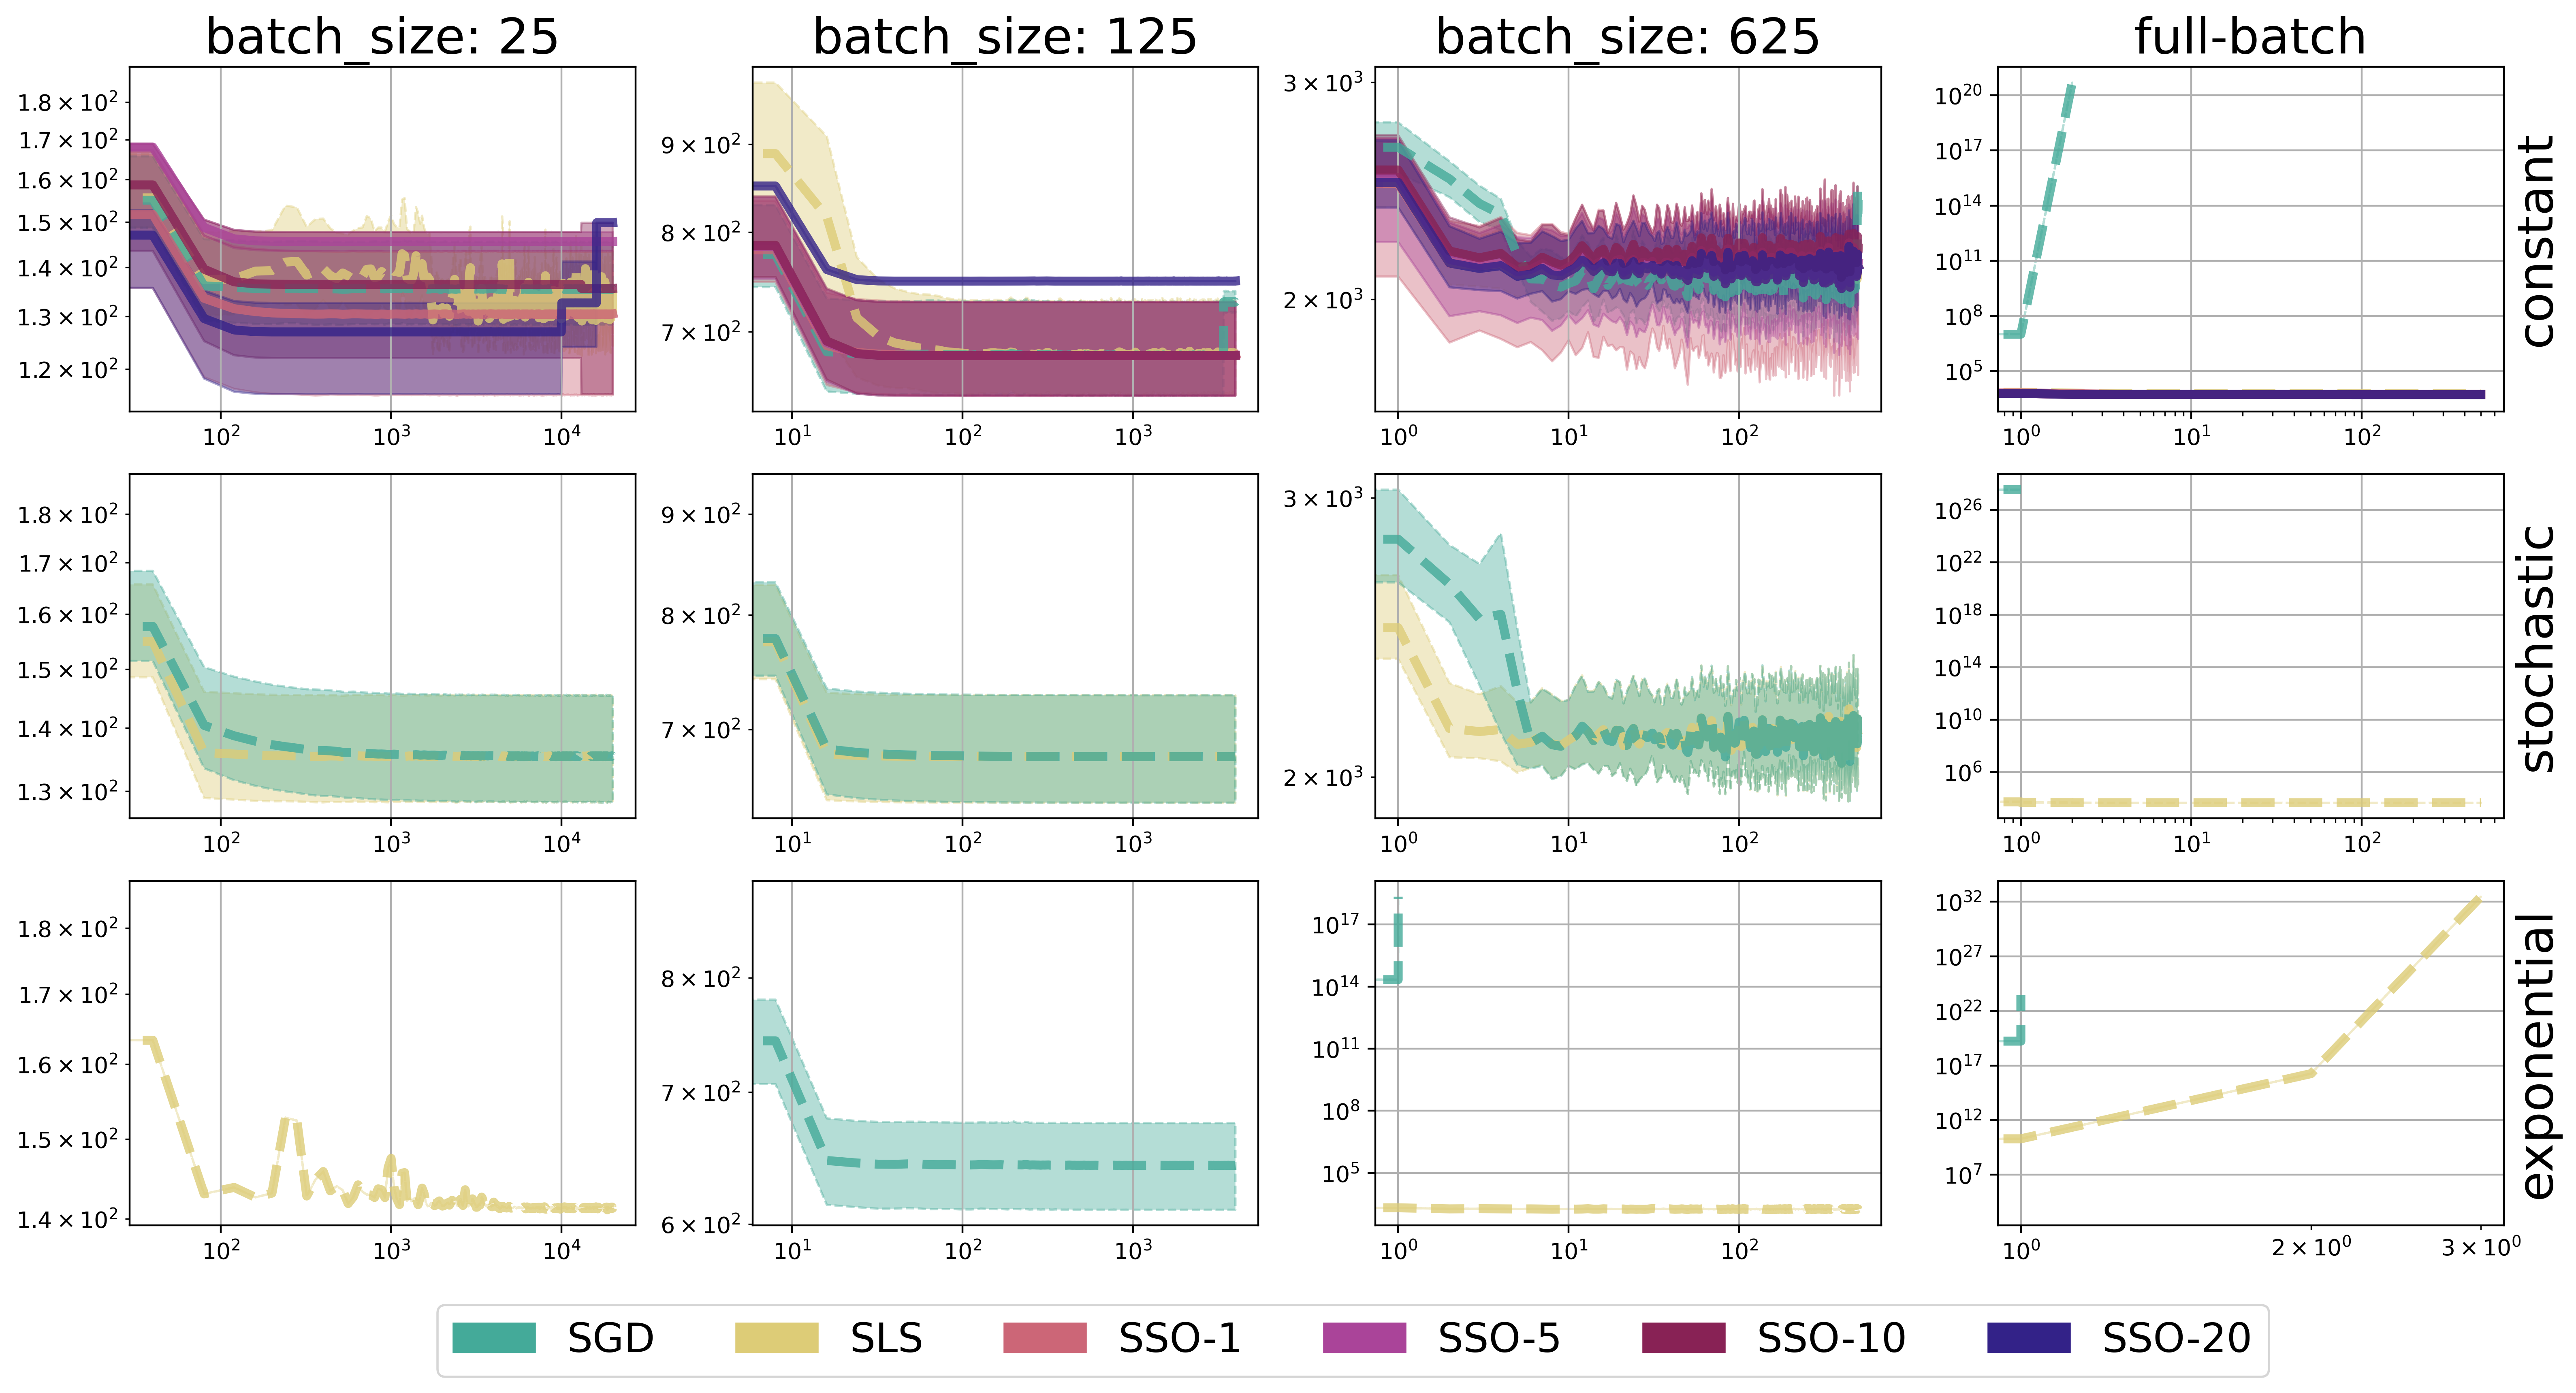

In [14]:
generate_mfac_figure('MSELoss', wandb_records) 